# Neal's funnel $f_{\nu}(x) = \mathcal{N}(x_1; 0,9) \mathcal{N}_{d-1}(x_{2:d}; 0, \exp(x_1) \cdot I_{d-1})$

Takes roughly rtf $\cdot$ 3 minutes to run.

For the normalization "constant", note  
$\log(\prod_{i=2}^d (\sigma^2)^{-1/2}) 
= \log((\sigma^2)^{-(d-1)/2})
= -(d-1)/2 \cdot \log(\sigma^2)$  
and  
$-(d-1)/2 \cdot \log(\exp(x_1))
= -(d-1)/2 \cdot x_1$

In [1]:
import timed_slice_sampling as tss
import plotting_functions as pfs
import numpy as np
import numpy.linalg as alg
import scipy.stats as sts
import matplotlib.pyplot as plt

## Preparation

In [2]:
d = 10
w = 5
path_prefix = "../plots/Neals_funnel_"
rtf = 1.0 # runtime factor (each sampler is awarded rtf minutes runtime)

In [3]:
def log_density(x):
    x = x.reshape(-1)
    return -(x[0]**2)/18 - (d-1)/2*x[0] - np.sum(x[1:]**2)/(2*np.exp(x[0]))

In [4]:
x_0 = np.zeros(d)
x_0[0] = 2

In [5]:
# quantiles and correct values
q1 = 0.001 #0.0001
q2 = 0.999 #0.9999
v1 = sts.norm(0,3).ppf(q1)
v2 = sts.norm(0,3).ppf(q2)
print("abs of quantile: {}".format(v2))

abs of quantile: 9.27069691850344


In [6]:
def print_target_quantities(samples):
    print("Empirical mean of first marginal: {:.4f}".format(np.mean(samples[:,0])))
    print("Empirical standard deviation of first marginal: {:.3f}".format(np.std(samples[:,0])))
    print("Empirical {:.4f} quantile: {:.3f}".format(q1, np.quantile(samples[:,0], q1)))
    print("Empirical {:.4f} quantile: {:.3f}".format(q2, np.quantile(samples[:,0], q2)))

## Running the samplers

In [7]:
itnum_gpss = int(rtf * 4e5)

In [8]:
samples_gpss, times_gpss = tss.gibbsian_polar_ss(log_density, x_0, w, itnum_gpss)

In [9]:
print_target_quantities(samples_gpss)

Empirical mean of first marginal: 0.0059
Empirical standard deviation of first marginal: 3.067
Empirical 0.0010 quantile: -9.495
Empirical 0.9990 quantile: 9.719


In [10]:
itnum_hruss = int(rtf * 1e6)

In [11]:
samples_hruss, times_hruss = tss.hit_and_run_uniform_ss(log_density, x_0, w, itnum_hruss)

In [12]:
print_target_quantities(samples_hruss)

Empirical mean of first marginal: 0.1619
Empirical standard deviation of first marginal: 3.097
Empirical 0.0010 quantile: -7.235
Empirical 0.9990 quantile: 10.057


In [13]:
itnum_ess = int(rtf * 4e5)
var = np.concatenate([np.array([9.0]), 70*np.ones(d-1)])
log_likelihood = lambda x: -tss.log_prior_indep(var, x) + log_density(x)

In [14]:
samples_ess, times_ess = tss.elliptical_ss(var, log_likelihood, x_0, itnum_ess)

In [15]:
print_target_quantities(samples_ess)

Empirical mean of first marginal: 0.4741
Empirical standard deviation of first marginal: 2.429
Empirical 0.0010 quantile: -4.547
Empirical 0.9990 quantile: 7.181


## Initial Processing of Outputs

In [16]:
algnames = ["GPSS", "HRUSS", "ESS"]
long_algnames = ["Gibbsian Polar S.S.", "Hit-and-Run Uniform S.S.", "Elliptical S.S."]
times = [times_gpss, times_hruss, times_ess]
tmax = int(rtf * 60) # retroactive runtime budget in seconds
total_its = [np.searchsorted(ts, tmax) for ts in times]
samples = [samples_gpss[:total_its[0]], samples_hruss[:total_its[1]], samples_ess[:total_its[2]]]
marginal_samples = [sams[:,0] for sams in samples]
radii = [alg.norm(sams, axis=1) for sams in samples]
nsam = len(algnames)

In [17]:
for i in range(3):
    print("{}: {} samples".format(algnames[i], total_its[i]))

GPSS: 365503 samples
HRUSS: 901185 samples
ESS: 361326 samples


## Convergence Analysis

In [18]:
default_cycler = plt.rcParams["axes.prop_cycle"]
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0, 0.9, nsam)))

In [19]:
nspots = 10 * tmax # number of spots in time at which convergence is to be assessed 
spots = np.linspace(tmax/nspots, tmax, nspots) # spots in time at which convergence is to be assessed

In [20]:
means = np.zeros((nsam, nspots))
stds = np.zeros((nsam, nspots))
q1s = np.zeros((nsam, nspots))
q2s = np.zeros((nsam, nspots))

In [21]:
for i in range(nsam):
    # binary search for number of iterations performed up to each spot
    its = np.searchsorted(times[i], spots)
    for j, it in enumerate(its):
        means[i,j] = np.mean(marginal_samples[i][:it])
        stds[i,j] = np.std(marginal_samples[i][:it])
        q1s[i,j] = np.quantile(marginal_samples[i][:it], q1)
        q2s[i,j] = np.quantile(marginal_samples[i][:it], q2)

In [22]:
conv_figsize = (4.5,3)
dpi = 250

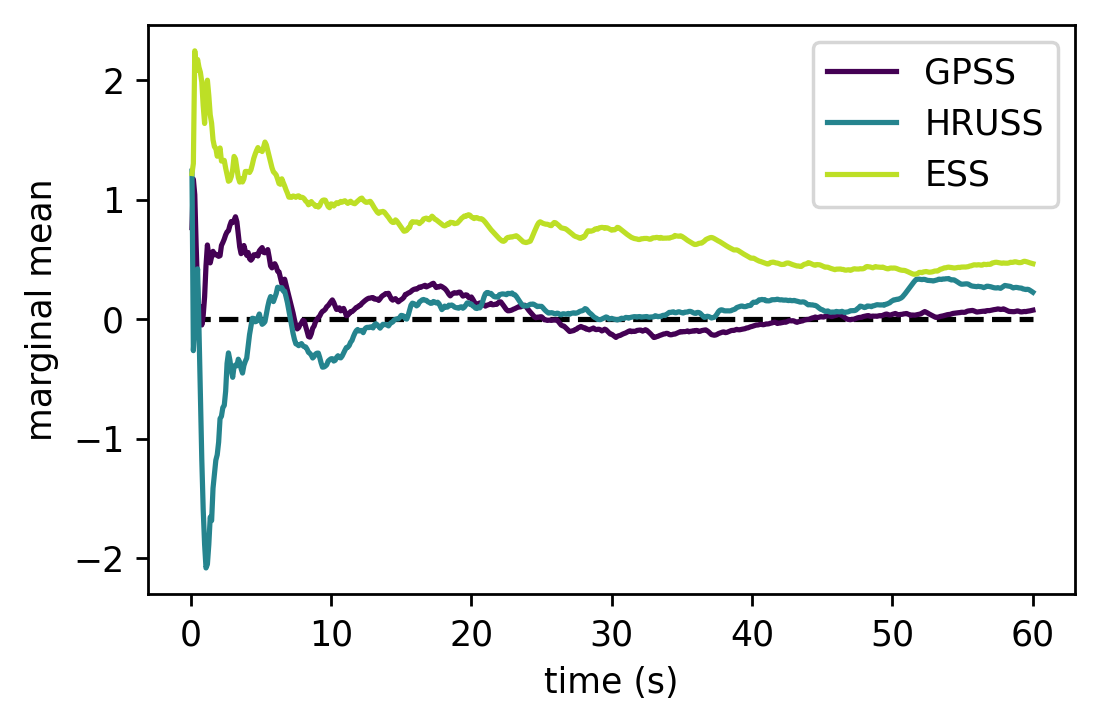

In [23]:
plt.figure(figsize=conv_figsize, dpi=dpi)
plt.xlabel("time (s)")
plt.ylabel("marginal mean")
for s in range(nsam):
    plt.plot(spots, means[s])
plt.plot([0,tmax], [0,0], color="black", linestyle="dashed", zorder=0)
plt.legend(algnames)
plt.tight_layout()
plt.savefig(path_prefix + "mean_conv.png")
plt.show()

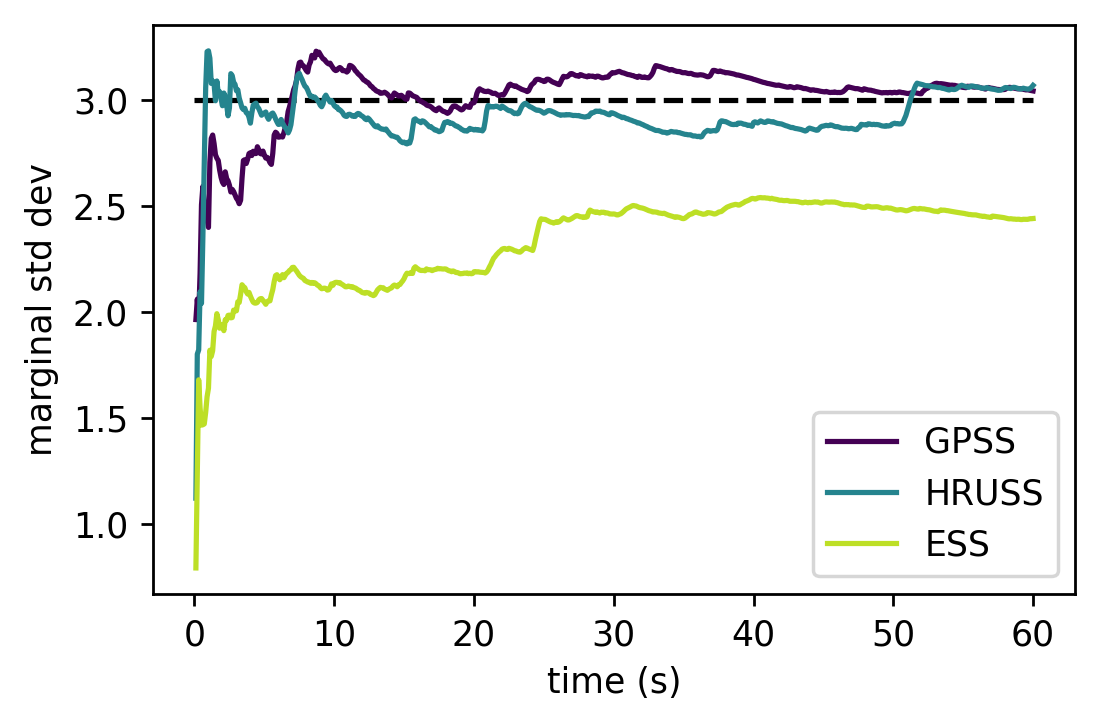

In [24]:
plt.figure(figsize=conv_figsize, dpi=dpi)
plt.xlabel("time (s)")
plt.ylabel("marginal std dev")
for s in range(nsam):
    plt.plot(spots, stds[s])
plt.plot([0,tmax], [3,3], color="black", linestyle="dashed", zorder=0)
plt.legend(algnames)
plt.tight_layout()
plt.savefig(path_prefix + "std_conv.png")
plt.show()

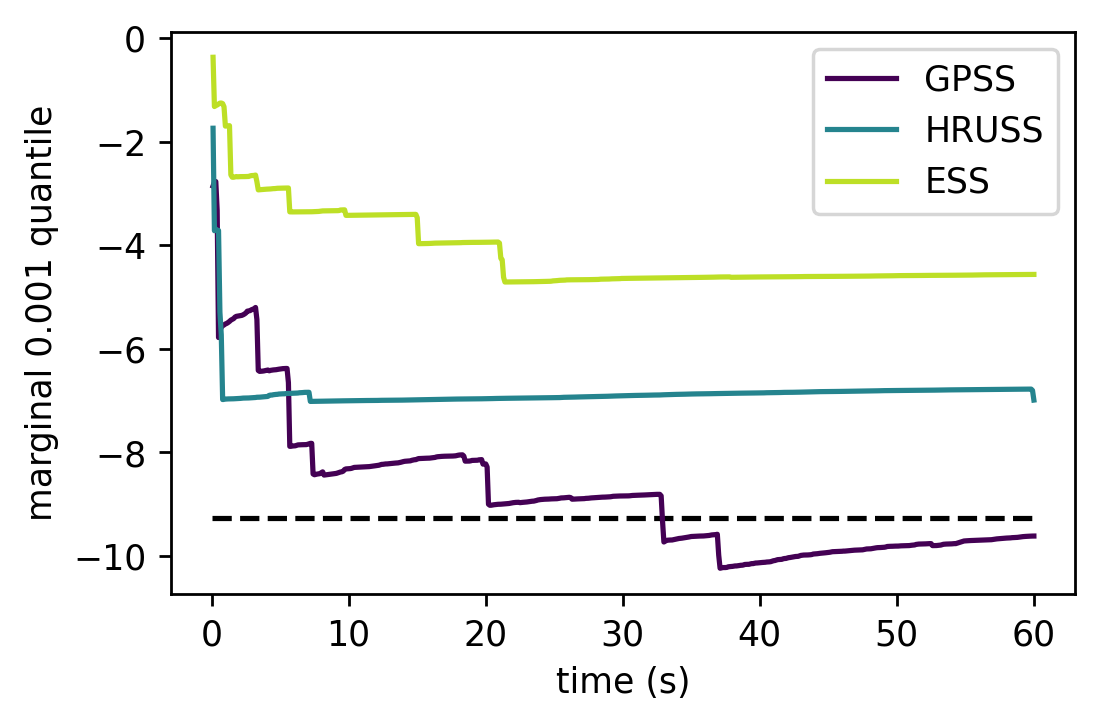

In [25]:
plt.figure(figsize=conv_figsize, dpi=dpi)
plt.xlabel("time (s)")
plt.ylabel("marginal {} quantile".format(q1))
for s in range(nsam):
    plt.plot(spots, q1s[s])
plt.plot([0,tmax], [v1,v1], color="black", linestyle="dashed", zorder=0)
plt.legend(algnames, loc="upper right")
plt.tight_layout()
plt.savefig(path_prefix + "q1_conv.png")
plt.show()

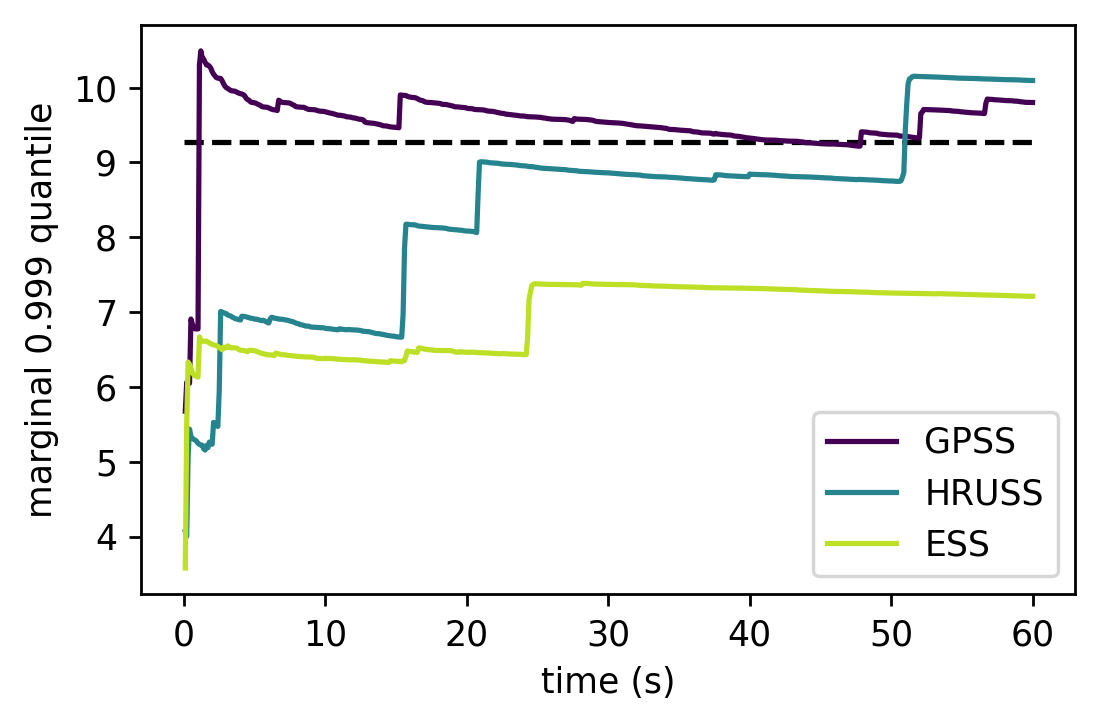

In [26]:
plt.figure(figsize=conv_figsize, dpi=dpi)
plt.xlabel("time (s)")
plt.ylabel("marginal {} quantile".format(q2))
for s in range(nsam):
    plt.plot(spots, q2s[s])
plt.plot([0,tmax], [v2,v2], color="black", linestyle="dashed", zorder=0)
plt.legend(algnames)
plt.tight_layout()
plt.savefig(path_prefix + "q2_conv.png")
plt.show()

In [27]:
plt.rcParams["axes.prop_cycle"] = default_cycler

## Additional Plotting

In [28]:
def plot_histogram_and_marginal_and_radii(msamples, vals, snames, figsize=(10,6), nbins=100, window=int(1e4), linewidth=None, filepath=None):
    nsam = len(snames)
    if linewidth == None:
        linewidth = min(1e3/window, 1.0)
    plt.figure(figsize=figsize, dpi=dpi, constrained_layout=True)
    # left column: marginal trace plot (a window)
    for i in range(nsam):
        ax = plt.subplot(nsam, 3, 1 + 3 * i)
        ax.set_ylabel(snames[i], fontdict={'size': 12})
        ax.set_xlim(0,window)
        if i < 2:
            ax.set_xticks([])
        else:
            #ax.set_xticks(np.arange(0,1e4+1,2e3), ["0", "2e3", "4e3", "6e3", "8e3", "1e4"])
            ax.set_xticks(np.arange(0,1e4,3e3))
        ax.set_ylim(-9,9)
        ax.set_yticks(range(-8,9,4))
        ax.plot(msamples[i][-window:], linewidth=linewidth)
    # middle column: histograms and target marginals
    x0s = np.linspace(-12, 12, 1000)
    for i in range(nsam):
        ax = plt.subplot(nsam, 3, 2 + 3 * i)
        ax.set_xlim((-12,12))
        if i < 2:
            ax.set_xticks([])
        ax.set_ylim((0.0,0.15))
        ax.set_yticks([]) #(np.arange(0, 0.15, 0.02))
        ax.hist(msamples[i], bins=nbins, density=True)
        ax.plot(x0s, sts.norm.pdf(x0s, 0, 3), color="black")
    # right column: radii trace plot (a window)
    for i in range(nsam):
        ax = plt.subplot(nsam, 3, 3 + 3 * i)
        ax.set_xlim(0,window)
        if i < 2:
            ax.set_xticks([])
        else:
            #ax.set_xticks(np.arange(0,1e4+1,2e3), ["0", "2e3", "4e3", "6e3", "8e3", "1e4"])
            ax.set_xticks(np.arange(0,1e4,3e3))
        ax.yaxis.tick_right()
        ax.plot(vals[i][-window:], linewidth=linewidth)
    if filepath != None:
        plt.savefig(filepath)
    plt.show()

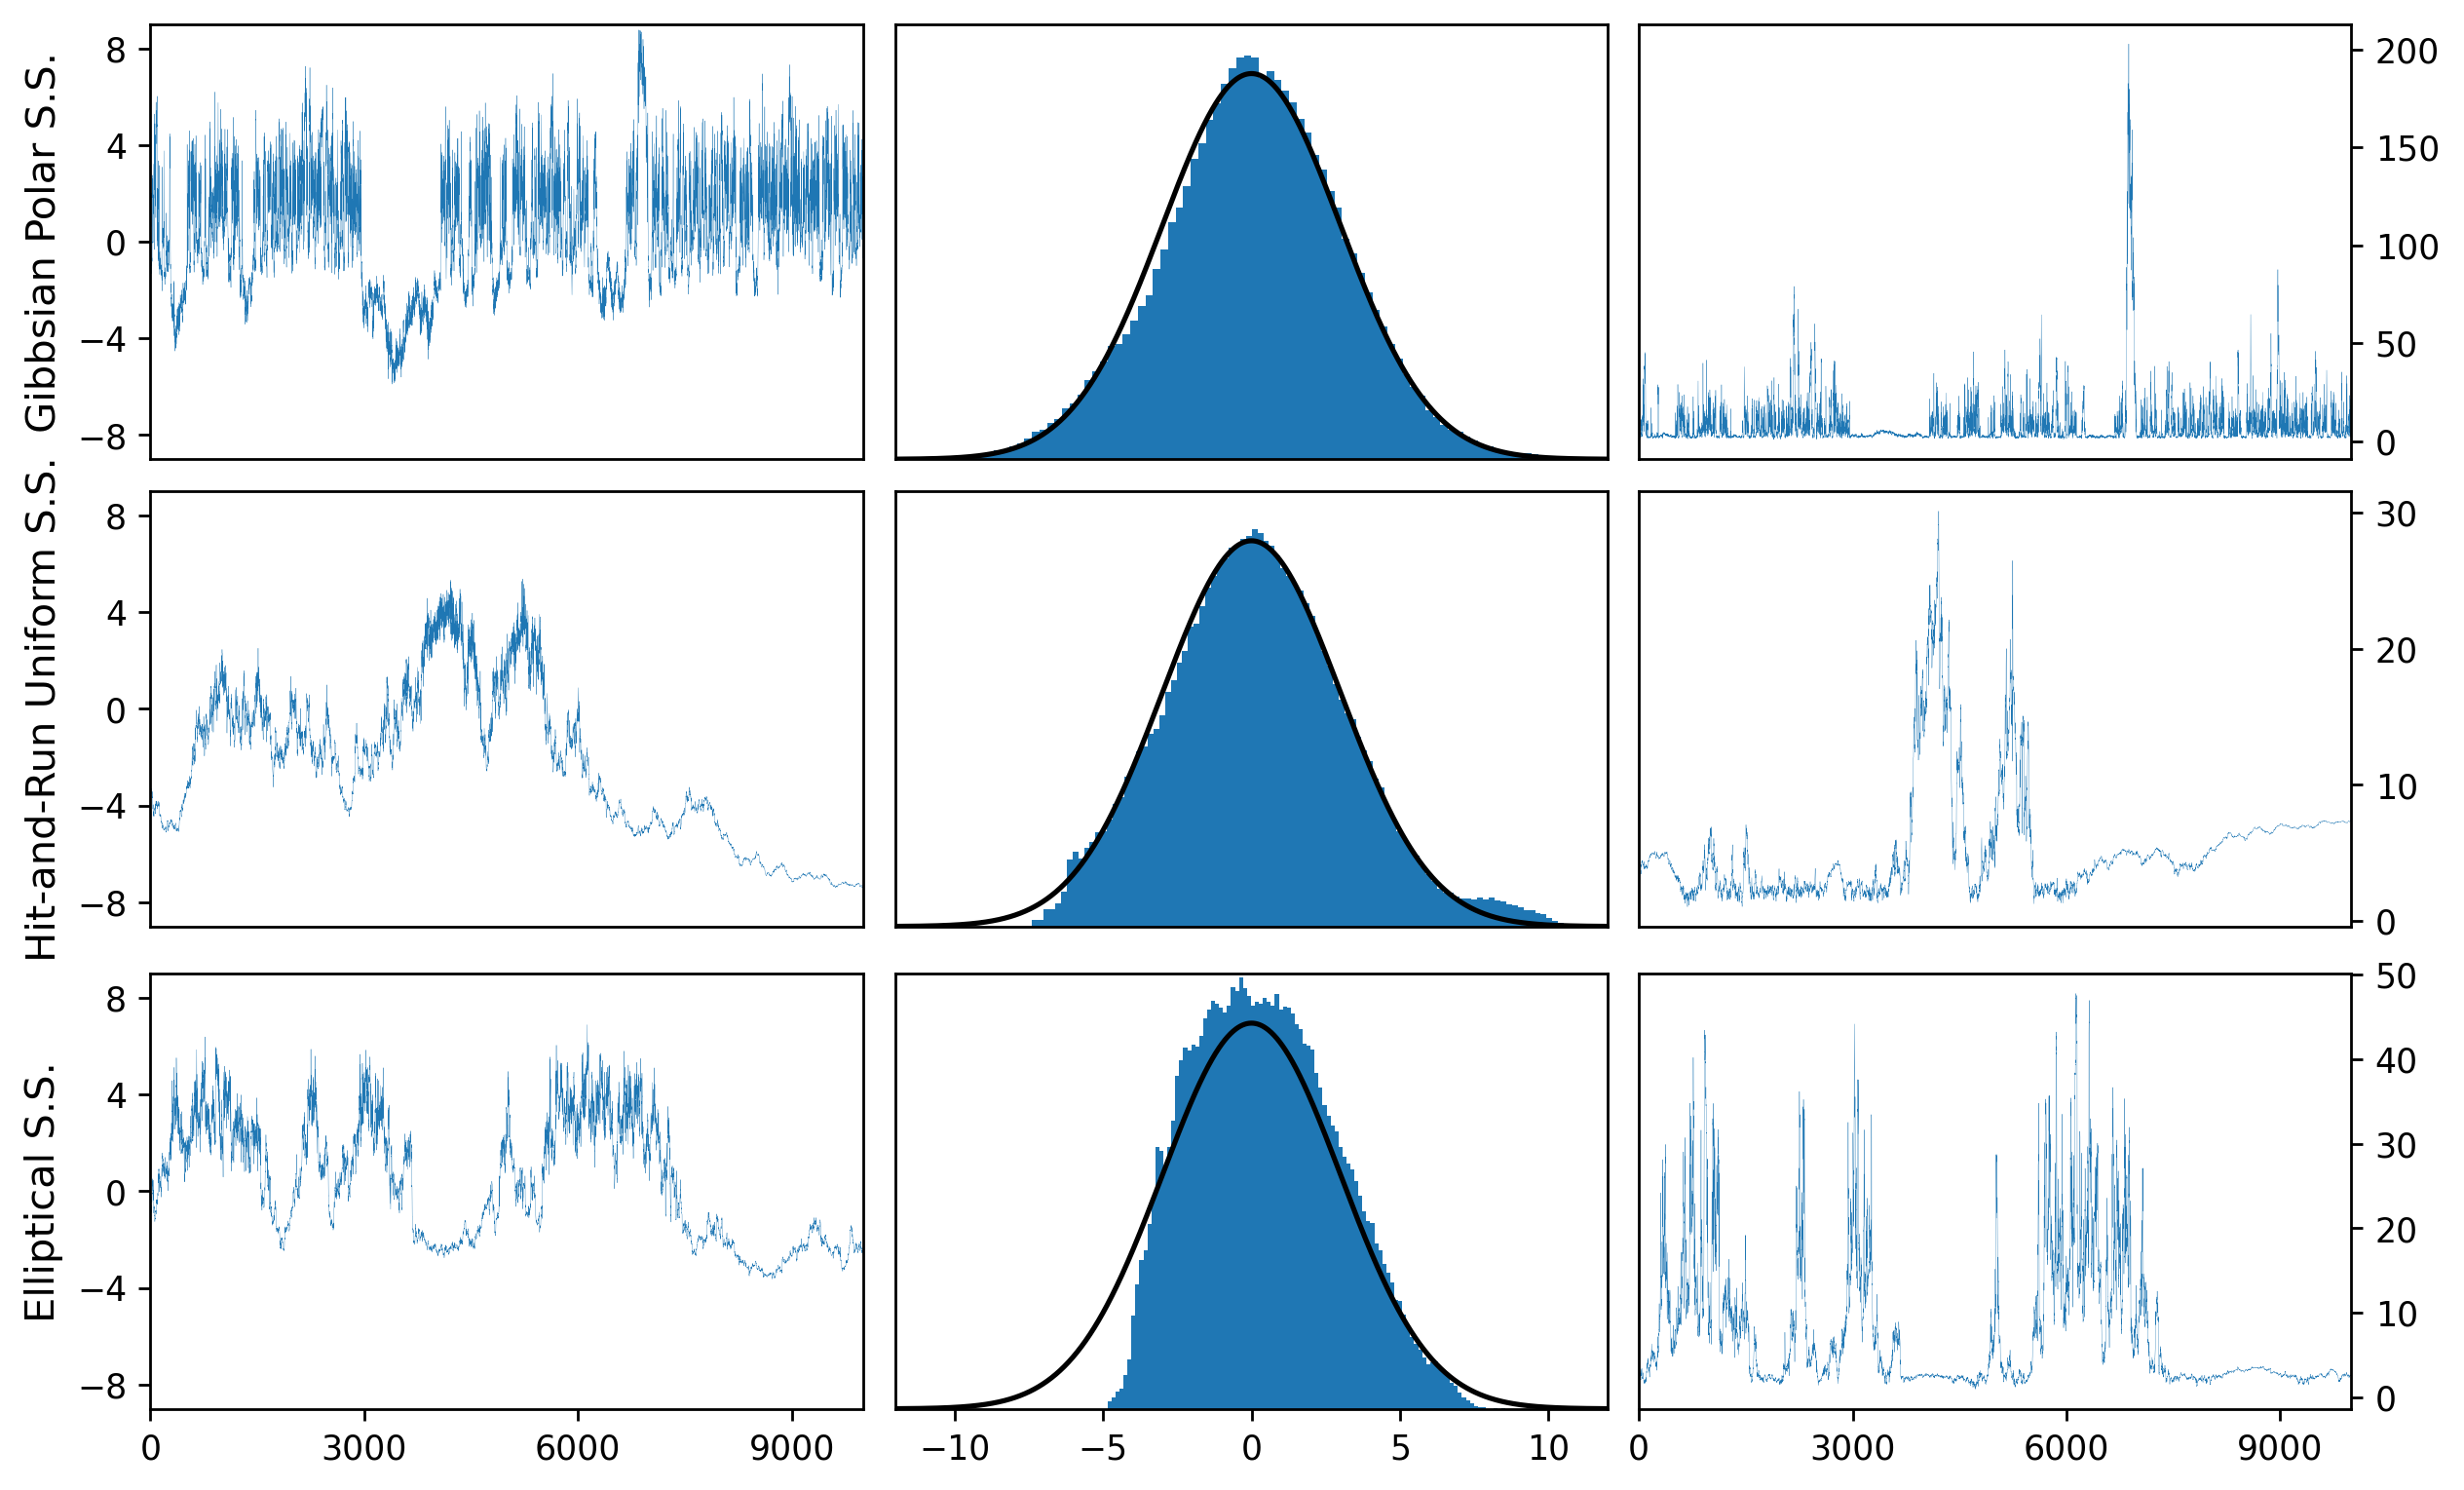

In [29]:
plot_histogram_and_marginal_and_radii(marginal_samples, radii, long_algnames, filepath = path_prefix + "histograms_marginals_radii.png")